The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu112==1.9.1
!pip install d2l==1.0.0-beta0


# Recurrent Neural Network Implementation from Scratch
:label:`sec_rnn-scratch`

We are now ready to implement an RNN from scratch.
In particular, we will train this RNN to function
as a character-level language model
(see :numref:`sec_rnn`)
and train it on a corpus consisting of 
the entire text of H. G. Wells' *The Time Machine*,
following the data processing steps 
outlined in :numref:`sec_text-sequence`.
We start by loading the dataset.


In [1]:
%matplotlib inline
import math
from mxnet import autograd, gluon, np, npx
from d2l import mxnet as d2l

npx.set_np()

## RNN Model

We begin by defining a class 
to implement the RNN model
(:numref:`subsec_rnn_w_hidden_states`).
Note that the number of hidden units `num_hiddens` 
is a tunable hyperparameter.


In [2]:
class RNNScratch(d2l.Module):  #@save
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = np.random.randn(num_inputs, num_hiddens) * sigma
        self.W_hh = np.random.randn(
            num_hiddens, num_hiddens) * sigma
        self.b_h = np.zeros(num_hiddens)

[**The `forward` method below defines how to compute 
the output and hidden state at any time step,
given the current input and the state of the model
at the previous time step.**]
Note that the RNN model loops through 
the outermost dimension of `inputs`,
updating the hidden state 
one time step at a time.
The model here uses a $\tanh$ activation function (:numref:`subsec_tanh`).


In [3]:
@d2l.add_to_class(RNNScratch)  #@save
def forward(self, inputs, state=None):
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = np.zeros((inputs.shape[1], self.num_hiddens),
                          ctx=inputs.ctx)
    else:
        state, = state
    outputs = []
    for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
        state = np.tanh(np.dot(X, self.W_xh) +
                         np.dot(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state

We can feed a minibatch of input sequences into an RNN model as follows.


In [4]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = np.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

[17:19:01] ../src/storage/storage.cc:196: Using Pooled (Naive) StorageManager for CPU


Let's check whether the RNN model
produces results of the correct shapes
to ensure that the dimensionality 
of the hidden state remains unchanged.


In [5]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

## RNN-Based Language Model

The following `RNNLMScratch` class defines 
an RNN-based language model,
where we pass in our RNN 
via the `rnn` argument
of the `__init__` method.
When training language models, 
the inputs and outputs are 
from the same vocabulary. 
Hence, they have the same dimension,
which is equal to the vocabulary size.
Note that we use perplexity to evaluate the model. 
As discussed in :numref:`subsec_perplexity`, this ensures 
that sequences of different length are comparable.


In [6]:
class RNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = np.random.randn(
            self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma
        self.b_q = np.zeros(self.vocab_size)
        for param in self.get_scratch_params():
            param.attach_grad()
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', np.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', np.exp(l), train=False)

### [**One-Hot Encoding**]

Recall that each token is represented 
by a numerical index indicating the
position in the vocabulary of the 
corresponding word/character/word piece.
You might be tempted to build a neural network
with a single input node (at each time step),
where the index could be fed in as a scalar value.
This works when we are dealing with numerical inputs 
like price or temperature, where any two values
sufficiently close together
should be treated similarly.
But this does not quite make sense. 
The $45^{\textrm{th}}$ and $46^{\textrm{th}}$ words 
in our vocabulary happen to be "their" and "said",
whose meanings are not remotely similar.

When dealing with such categorical data,
the most common strategy is to represent
each item by a *one-hot encoding*
(recall from :numref:`subsec_classification-problem`).
A one-hot encoding is a vector whose length
is given by the size of the vocabulary $N$,
where all entries are set to $0$,
except for the entry corresponding 
to our token, which is set to $1$.
For example, if the vocabulary had five elements,
then the one-hot vectors corresponding 
to indices 0 and 2 would be the following.


In [7]:
npx.one_hot(np.array([0, 2]), 5)

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

(**The minibatches that we sample at each iteration
will take the shape (batch size, number of time steps).
Once representing each input as a one-hot vector,
we can think of each minibatch as a three-dimensional tensor, 
where the length along the third axis 
is given by the vocabulary size (`len(vocab)`).**)
We often transpose the input so that we will obtain an output 
of shape (number of time steps, batch size, vocabulary size).
This will allow us to loop more conveniently through the outermost dimension
for updating hidden states of a minibatch,
time step by time step
(e.g., in the above `forward` method).


In [8]:
@d2l.add_to_class(RNNLMScratch)  #@save
def one_hot(self, X):
    # Output shape: (num_steps, batch_size, vocab_size)
    return npx.one_hot(X.T, self.vocab_size)

### Transforming RNN Outputs

The language model uses a fully connected output layer
to transform RNN outputs into token predictions at each time step.


In [9]:
@d2l.add_to_class(RNNLMScratch)  #@save
def output_layer(self, rnn_outputs):
    outputs = [np.dot(H, self.W_hq) + self.b_q for H in rnn_outputs]
    return np.stack(outputs, 1)

@d2l.add_to_class(RNNLMScratch)  #@save
def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)

Let's [**check whether the forward computation
produces outputs with the correct shape.**]


In [10]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(np.ones((batch_size, num_steps), dtype=np.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

## [**Gradient Clipping**]


While you are already used to thinking of neural networks
as "deep" in the sense that many layers
separate the input and output 
even within a single time step,
the length of the sequence introduces
a new notion of depth.
In addition to the passing through the network
in the input-to-output direction,
inputs at the first time step
must pass through a chain of $T$ layers
along the time steps in order 
to influence the output of the model
at the final time step.
Taking the backwards view, in each iteration,
we backpropagate gradients through time,
resulting in a chain of matrix-products 
of length  $\mathcal{O}(T)$.
As mentioned in :numref:`sec_numerical_stability`, 
this can result in numerical instability, 
causing the gradients either to explode or vanish,
depending on the properties of the weight matrices. 

Dealing with vanishing and exploding gradients 
is a fundamental problem when designing RNNs
and has inspired some of the biggest advances
in modern neural network architectures.
In the next chapter, we will talk about
specialized architectures that were designed
in hopes of mitigating the vanishing gradient problem.
However, even modern RNNs often suffer
from exploding gradients.
One inelegant but ubiquitous solution
is to simply clip the gradients 
forcing the resulting "clipped" gradients
to take smaller values. 


Generally speaking, when optimizing some objective
by gradient descent, we iteratively update
the parameter of interest, say a vector $\mathbf{x}$,
but pushing it in the direction of the 
negative gradient $\mathbf{g}$
(in stochastic gradient descent, 
we calculate this gradient
on a randomly sampled minibatch).
For example, with learning rate $\eta > 0$,
each update takes the form 
$\mathbf{x} \gets \mathbf{x} - \eta \mathbf{g}$.
Let's further assume that the objective function $f$
is sufficiently smooth. 
Formally, we say that the objective 
is *Lipschitz continuous* with constant $L$,
meaning that for any $\mathbf{x}$ and $\mathbf{y}$, we have

$$|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|.$$

As you can see, when we update the parameter vector by subtracting $\eta \mathbf{g}$,
the change in the value of the objective
depends on the learning rate,
the norm of the gradient and $L$ as follows:

$$|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|.$$

In other words, the objective cannot
change by more than $L \eta \|\mathbf{g}\|$. 
Having a small value for this upper bound 
might be viewed as good or bad.
On the downside, we are limiting the speed
at which we can reduce the value of the objective.
On the bright side, this limits by just how much
we can go wrong in any one gradient step.


When we say that gradients explode, 
we mean that $\|\mathbf{g}\|$ 
becomes excessively large.
In this worst case, we might do so much
damage in a single gradient step that we
could undo all of the progress made over
the course of thousands of training iterations.
When gradients can be so large,
neural network training often diverges,
failing to reduce the value of the objective.
At other times, training eventually converges
but is unstable owing to massive spikes in the loss.


One way to limit the size of $L \eta \|\mathbf{g}\|$ 
is to shrink the learning rate $\eta$ to tiny values.
This has the advantage that we do not bias the updates.
But what if we only *rarely* get large gradients?
This drastic move slows down our progress at all steps,
just to deal with the rare exploding gradient events.
A popular alternative is to adopt a *gradient clipping* heuristic
projecting the gradients $\mathbf{g}$ onto a ball 
of some given radius $\theta$ as follows:

(**$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$**)

This ensures that the gradient norm never exceeds $\theta$ 
and that the updated gradient is entirely aligned 
with the original direction of $\mathbf{g}$.
It also has the desirable side-effect 
of limiting the influence any given minibatch 
(and within it any given sample) 
can exert on the parameter vector. 
This bestows a certain degree of robustness to the model. 
To be clear, it is a hack. 
Gradient clipping means that we are not always
following the true gradient and it is hard 
to reason analytically about the possible side effects.
However, it is a very useful hack,
and is widely adopted in RNN implementations
in most deep learning frameworks.


Below we define a method to clip gradients,
which is invoked by the `fit_epoch` method of
the `d2l.Trainer` class (see :numref:`sec_linear_scratch`).
Note that when computing the gradient norm,
we are concatenating all model parameters,
treating them as a single giant parameter vector.


In [11]:
@d2l.add_to_class(d2l.Trainer)  #@save
def clip_gradients(self, grad_clip_val, model):
    params = model.parameters()
    if not isinstance(params, list):
        params = [p.data() for p in params.values()]
    norm = math.sqrt(sum((p.grad ** 2).sum() for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

## Training

Using *The Time Machine* dataset (`data`),
we train a character-level language model (`model`)
based on the RNN (`rnn`) implemented from scratch.
Note that we first calculate the gradients,
then clip them, and finally 
update the model parameters
using the clipped gradients.


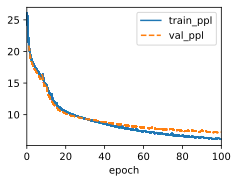

In [12]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## Decoding

Once a language model has been learned,
we can use it not only to predict the next token
but to continue predicting each subsequent one,
treating the previously predicted token as though
it were the next in the input. 
Sometimes we will just want to generate text
as though we were starting at the beginning 
of a document. 
However, it is often useful to condition
the language model on a user-supplied prefix.
For example, if we were developing an
autocomplete feature for a search engine
or to assist users in writing emails,
we would want to feed in what they 
had written so far (the prefix), 
and then generate a likely continuation.


[**The following `predict` method
generates a continuation, one character at a time,
after ingesting a user-provided `prefix`**].
When looping through the characters in `prefix`,
we keep passing the hidden state
to the next time step 
but do not generate any output.
This is called the *warm-up* period.
After ingesting the prefix, we are now
ready to begin emitting the subsequent characters,
each of which will be fed back into the model 
as the input at the next time step.


In [13]:
@d2l.add_to_class(RNNLMScratch)  #@save
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = np.array([[outputs[-1]]], ctx=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In the following, we specify the prefix 
and have it generate 20 additional characters.


In [14]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has in the the the the '

While implementing the above RNN model from scratch is instructive, it is not convenient.
In the next section, we will see how to leverage deep learning frameworks to whip up RNNs
using standard architectures, and to reap performance gains 
by relying on highly optimized library functions.


## Summary

We can train RNN-based language models to generate text following the user-provided text prefix. 
A simple RNN language model consists of input encoding, RNN modeling, and output generation.
During training, gradient clipping can mitigate the problem of exploding gradients but does not address the problem of vanishing gradients. In the experiment, we implemented a simple RNN language model and trained it with gradient clipping on sequences of text, tokenized at the character level. By conditioning on a prefix, we can use a language model to generate likely continuations, which proves useful in many applications, e.g., autocomplete features.


## Exercises

1. Does the implemented language model predict the next token based on all the past tokens up to the very first token in *The Time Machine*? 
1. Which hyperparameter controls the length of history used for prediction?
1. Show that one-hot encoding is equivalent to picking a different embedding for each object.
1. Adjust the hyperparameters (e.g., number of epochs, number of hidden units, number of time steps in a minibatch, and learning rate) to improve the perplexity. How low can you go while sticking with this simple architecture?
1. Replace one-hot encoding with learnable embeddings. Does this lead to better performance?
1. Conduct an experiment to determine how well this language model 
   trained on *The Time Machine* works on other books by H. G. Wells,
   e.g., *The War of the Worlds*.
1. Conduct another experiment to evaluate the perplexity of this model
   on books written by other authors. 
1. Modify the prediction method so as to use sampling 
   rather than picking the most likely next character.
    * What happens?
    * Bias the model towards more likely outputs, e.g., 
    by sampling from $q(x_t \mid x_{t-1}, \ldots, x_1) \propto P(x_t \mid x_{t-1}, \ldots, x_1)^\alpha$ for $\alpha > 1$.
1. Run the code in this section without clipping the gradient. What happens?
1. Replace the activation function used in this section with ReLU 
   and repeat the experiments in this section. Do we still need gradient clipping? Why?


[Discussions](https://discuss.d2l.ai/t/336)
